# 0.Import the Libraries

In [ ]:
pip install optuna

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor , plot_importance
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import warnings
import optuna
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

# 1.DATA LOADING & INITIAL CLEANING

- Load all datasets and perform initial cleaning


In [ ]:
def load_and_clean_data():

    print("=" * 80)
    print("Loading Data:")
    print("=" * 80)

    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')
    calendar = pd.read_csv('calendar.csv')
    reviews = pd.read_csv('reviews.csv')

    print(f"Train shape: {train.shape}")
    print(f"Test shape: {test.shape}")
    print(f"Calendar shape: {calendar.shape}")
    print(f"Reviews shape: {reviews.shape}")

    return train, test, calendar, reviews




`initial_cleaning`
- Remove Useless columns
- Fix price replacing , with space
- Replace missing prices with property + room_type
- Remove Outlier
- Get log price

In [ ]:
def initial_cleaning(df, is_train=True):
    """Basic cleaning - remove useless columns"""

    drop_cols = [
        "Unnamed: 0", "Unnamed: 0.1", "scrape_id", "last_scraped", "source",
        "listing_url", "host_url", "host_thumbnail_url", "host_picture_url",
        "picture_url", "host_neighbourhood", "neighbourhood_group_cleansed",
        "license", "neighbourhood_overview", "neighborhood_overview",
        "host_location", "host_about", "host_response_time", "neighbourhood"
    ]

    df = df.drop(columns=[col for col in drop_cols if col in df.columns])

    # Fix price for training data
    if is_train and 'price' in df.columns:
        df["price"] = (
            df["price"]
            .str.replace(",", "", regex=False)
            .astype(float)
        )

        # Fill missing prices by property_type + room_type median
        df["price"] = df.groupby(["property_type", "room_type"])["price"].transform(
            lambda x: x.fillna(x.median())
        )

        # Remove outliers (top 1%)
        upper_limit = df['price'].quantile(0.99)
        df = df[df['price'] <= upper_limit].copy()

        # Create log price target
        df['log_price'] = np.log1p(df['price'])

    return df


`eda`

In [ ]:
def run_eda_suite(df):
    """Visualizes key distributions and relationships"""

    print("\n" + "=" * 80)
    print("GENERATING EDA PLOTS")
    print("=" * 80)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Target Distribution: Check for Skewness
    sns.histplot(df['price'], kde=True, ax=axes[0, 0], color='teal')
    axes[0, 0].set_title('Distribution of Price (Target)')

    # 2. Price by Room Type: Categorical Impact
    sns.boxplot(x='room_type', y='price', data=df, ax=axes[0, 1])
    axes[0, 1].set_title('Price vs Room Type')
    axes[0, 1].tick_params(axis='x', rotation=45)

    # 3. Geographic Heatmap
    # This helps visualize if 'dist_to_center' is sufficient
    scatter = axes[1, 0].scatter(df['longitude'], df['latitude'], c=df['price'],
                                 cmap='viridis', alpha=0.5, s=10)
    plt.colorbar(scatter, ax=axes[1, 0], label='Price')
    axes[1, 0].set_title('Geographic Price Heatmap')

    # 4. Correlation Heatmap
    cols_to_check = ['price', 'accommodates', 'bedrooms', 'bathrooms', 'review_scores_rating']
    sns.heatmap(df[cols_to_check].corr(), annot=True, cmap='coolwarm', fmt=".2f", ax=axes[1, 1])
    axes[1, 1].set_title('Correlation Matrix')

    plt.tight_layout()
    plt.show()

# 2.CALENDAR FEATURES

`create_calendar_features`
- This function extracts demand-related features from the calendar dataset.
- It summarizes availability patterns over multiple time windows (short-term and medium-term) and estimates booking activity per listing.
- These features shows how frequently a listing is available or booked, hich is a strong indicator for popularity and pricing dynamics.


In [ ]:
def create_calendar_features(calendar_df, df):
    """Extract  features from calendar availability"""

    print("\n" + "=" * 80)
    print("CREATING CALENDAR FEATURES")
    print("=" * 80)

    # Convert Dates to Datetime and Availability( t / f) into numeric signals
    # 1 = available / 0 = booked

    calendar_df = calendar_df.copy()
    calendar_df['date'] = pd.to_datetime(calendar_df['date'])
    calendar_df['available_flag'] = (calendar_df['available'] == 't').astype(int)

    base_date = calendar_df['date'].min()

    # Create a time axis per listing
    # Each listing starts on a different date and `delta days`  compare listings
    # it prevents us from temporal bias through mixing calendar dates
    features_list = []

    calendar_df['start_date'] = calendar_df.groupby('listing_id')['date'].transform('min')
    calendar_df['delta_days'] = (calendar_df['date'] - calendar_df['start_date']).dt.days

    # We define different windows from 1 week to 3 months
    for days in [7, 30, 60, 90]:
        print(f"Processing {days}-day window...")

        # For each of those windows we compute :
            # mean: How often the listing is available (rate)
            # sum: total available day
        window_data = (
            calendar_df[calendar_df['delta_days'] <= days]
            .groupby('listing_id')
            .agg({
                'available_flag': ['mean', 'sum'],

                # Listing with higher min nights behave differently so we use this to find the constraints
                'minimum_nights': 'mean'
            })
        )

        window_data.columns = [
            f'{col[0]}_{col[1]}_{days}d' for col in window_data.columns
        ]

        features_list.append(window_data)



    # Count booking blocks per listing
    print("Detecting booking patterns...")

    calendar_sorted = calendar_df.sort_values(['listing_id', 'date'])
    calendar_sorted['is_booked'] = 1 - calendar_sorted['available_flag']

    # Detect new booking blocks by invert availaibility
    # This allows for finding start of the booking and avoid over-counting long stays
    calendar_sorted['new_block'] = (
        (calendar_sorted['is_booked'] == 1) &
        (calendar_sorted.groupby('listing_id')['is_booked'].shift(1) != 1)
    )

    booking_blocks = (
        calendar_sorted.groupby('listing_id')['new_block']
        .sum()
        .rename('estimated_bookings')
    )

    features_list.append(booking_blocks)

    # Combine all calendar features
    calendar_features = pd.concat(features_list, axis=1)

    # Merge with main dataframe
    result = df.merge(calendar_features, left_on='id', right_index=True, how='left')

    # Fill NaN with 0 (listings not in calendar)
    calendar_cols = calendar_features.columns.tolist()
    result[calendar_cols] = result[calendar_cols].fillna(0)

    print(f"Added {len(calendar_cols)} calendar features")

    return result


# 3. Review Features

`create_review_features`
- This function extracts review-based features that describe both the volume and the time dynamics of user feedback.
- It captures long-term popularity, recent activity, and review frequency, which are strong indicators of listing attractiveness and trustworthiness.


In [ ]:
def create_review_features(reviews_df, df):
    """Extract temporal review patterns"""

    print("\n" + "=" * 80)
    print("CREATING REVIEW FEATURES")
    print("=" * 80)

    # Transofr to the right datetime
    reviews_df = reviews_df.copy()
    reviews_df['date'] = pd.to_datetime(reviews_df['date'])

    # Total reviews: more reviews -> more demand -> higher prices
    total_reviews = reviews_df.groupby('listing_id').size().rename('total_reviews')

    # Recent activity (short and medium term )
    # erecent one matter more
    max_date = reviews_df['date'].max()

    recent_90 = reviews_df[reviews_df['date'] >= max_date - pd.Timedelta(days=90)]
    recent_90_count = recent_90.groupby('listing_id').size().rename('reviews_last_90d')

    recent_180 = reviews_df[reviews_df['date'] >= max_date - pd.Timedelta(days=180)]
    recent_180_count = recent_180.groupby('listing_id').size().rename('reviews_last_180d')

    # Review velocity (reviews per month): fair comparison btw old and new listing based how long it has been active
    # without it older listing always look better
    review_span = reviews_df.groupby('listing_id')['date'].agg(['min', 'max'])
    review_span['months_active'] = ((review_span['max'] - review_span['min']).dt.days / 30).replace(0, 1)
    review_velocity = (total_reviews / review_span['months_active']).rename('review_velocity')

    # Days since last review: good for recency
    days_since = ((max_date - reviews_df.groupby('listing_id')['date'].max()) / pd.Timedelta(days=1)).rename('days_since_last_review')

    # Combine
    review_features = pd.concat([
        total_reviews, recent_90_count, recent_180_count,
        review_velocity, days_since
    ], axis=1).fillna(0)

    result = df.merge(review_features, left_on='id', right_index=True, how='left')

    # Fill NaN for listings without reviews
    review_cols = review_features.columns.tolist()
    result[review_cols] = result[review_cols].fillna(0)

    print(f"Added {len(review_cols)} review features")

    return result


- We modeled review information not only by volume but also by recency and frequency.
- This allows the model to distinguish between historically popular listings and currently active ones

`create_amenities_features`
- This function transforms the unstructured amenities text into structured, interpretable numerical features.
- Amenities are grouped into meaningful categories (e.g. luxury, work, family).

In [ ]:
def create_amenities_features(df):
    """Extract structured amenities categories"""

    print("\n" + "=" * 80)
    print("CREATING AMENITIES FEATURES")
    print("=" * 80)

    # Define amenity categories to reflect real world usafe and reduce noise by grouping
    amenity_keywords = {
        'luxury': ['pool', 'gym', 'spa', 'sauna', 'jacuzzi', 'hot tub'],
        'work': ['wifi', 'desk', 'workspace', 'ethernet', 'monitor'],
        'family': ['crib', 'high chair', 'children', 'toys', 'games'],
        'kitchen': ['kitchen', 'stove', 'oven', 'microwave', 'refrigerator', 'dishwasher'],
        'parking': ['parking', 'garage', 'ev charger'],
        'outdoor': ['balcony', 'patio', 'garden', 'bbq', 'terrace', 'view'],
        'safety': ['alarm', 'detector', 'first aid', 'extinguisher', 'lock'],
        'entertainment': ['tv', 'netflix', 'cable', 'sound system']
    }

    # Handle missing and lowercase
    df['amenities_str'] = df['amenities'].fillna('').astype(str).str.lower()

    # Count per category: this gives a intensity feature which is more informatuive
    for category, keywords in amenity_keywords.items():
        pattern = '|'.join(keywords)
        df[f'amenity_{category}'] = df['amenities_str'].str.count(pattern)

    # Total amenities count
    df['total_amenities'] = df['amenities_str'].str.count(',') + 1

    # Luxury score
    df['luxury_score'] = (
        df['amenity_luxury'] * 3 +
        df['amenity_outdoor'] * 2 +
        df['amenity_entertainment'] * 1.5
    )

    # Drop raw text to avoid redundancy
    df = df.drop(columns=['amenities_str', 'amenities'])

    print(f"Added {len(amenity_keywords) + 2} amenity features")

    return df


- We converted the amenities text into structured categories to reduce noise while keeping interpretability.
- We also created a weighted luxury score to reflect amenities that typically increase willingness to pay.

# 5. Text Features

`create_text_features`
- This function extracts numerical representations from text fields (such as listing name and description) using TF-IDF.
- The goal is to capture frequently occurring keywords and short phrasesthat may influence pricing.


In [ ]:
def create_text_features(df, text_col, prefix, max_features=20, vectorizer=None):
    """Extract key features from text using TF-IDF"""

    print(f"Processing text column: {text_col}...")

    # Avoid missing values , fix datatype
    df[text_col] = df[text_col].fillna('').astype(str)

    # We fit only training data and reuse the same vocab for test as away to prevent leakage
    if vectorizer is None:
      # Tf-IDF highlights informative ones
        vectorizer = TfidfVectorizer(
            max_features=max_features,  # controls dimensionality
            stop_words='english',
            ngram_range=(1, 2),       # capture short phrases like city center
            min_df=5              # removes rare noisy words
        )
        tfidf_matrix = vectorizer.fit_transform(df[text_col])
    else:
        tfidf_matrix = vectorizer.transform(df[text_col])

    # Create feature names
    feature_names = [f'{prefix}_tfidf_{i}' for i in range(tfidf_matrix.shape[1])]
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names, index=df.index)

    # Concatenate
    result = pd.concat([df, tfidf_df], axis=1)

    return result, vectorizer

- We used TF-IDF to extract the most informative words and short phrases from listing text, while strictly limiting the number of features to avoid overfitting and data leakage.

# 6. Core Features Engineering

`fix_bathrooms`
- Bathroom information was inconsistently stored as text and numbers.
- Westandardized it by extracting numeric values from the text and using them to fill missing entries

In [ ]:
def fix_bathrooms(df):
    """Fix bathroom data"""

    # We use `bathrooms_text` informations that are in text
    if 'bathrooms_text' in df.columns:
      # We conecert text into numeric format
        df['bathrooms_text'] = (
            df['bathrooms_text']
            .astype(str)
            .str.replace('Half-bath', '0.5 baths', regex=False)
        )

        # We extracts integers and decimals and converts bathroom description into numbers
        df['bathrooms_calc'] = (
            df['bathrooms_text']
            .str.extract(r'(\d+\.?\d*)')
            .astype(float)
        )

        # Fill missing numerical bathrooms
        if 'bathrooms' in df.columns:
            df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms_calc'])
        else:
            df['bathrooms'] = df['bathrooms_calc']

        # Drop the columns
        df = df.drop(columns=['bathrooms_calc', 'bathrooms_text'])

    return df



`fix_review_score`
- Missing review scores usually indicate new or unreviewed listings.
- we explicitly modeled this using a binary flag and filled missing scores with zero to keep the data consistent

In [ ]:
def fix_review_scores(df):
    """Handle missing review scores"""

    # Define ewview score columns since they are split into multiple dimensions
    review_cols = [
        'review_scores_rating', 'review_scores_accuracy',
        'review_scores_cleanliness', 'review_scores_checkin',
        'review_scores_communication', 'review_scores_location',
        'review_scores_value'
    ]

    # Flag for unreviewed listings since missing score is dif than bad scores
    df['is_unreviewed'] = df['review_scores_rating'].isna().astype(int)

    # Fill with 0
    for col in review_cols:
        if col in df.columns:
            df[col] = df[col].fillna(0)

    return df



- Host response and acceptance rates are stored as percentage strings.
-We converted them into numeric values so they could be used reliably by the model

In [ ]:
def fix_rates(df):
    """Fix percentage columns"""

    # Get the percentage columns
    rate_cols = ['host_response_rate', 'host_acceptance_rate']

    for col in rate_cols:
      # Remove the percent symbol and handle missing value
        if col in df.columns:
            df[col] = (
                df[col]
                .astype(str)
                .str.replace('%', '', regex=False)
                .replace('nan', np.nan)
            )
            # Convert to numeric
            df[col] = pd.to_numeric(df[col], errors='coerce')

    return df




`create_ration_features`
- Raw counts don’t show how space is shared.
- These ratio and interaction features allow the model to capture density and layout quality

In [ ]:
def create_ratio_features(df):
    """Create ratio and interaction features"""

    print("\nCreating ratio features...")

    # Ratios
    # People per bedroom ->  measures crowding and affects comfort
    df['people_per_bedroom'] = df['accommodates'] / df['bedrooms'].replace(0, 1)

    # People per bathroom
    df['people_per_bathroom'] = df['accommodates'] / df['bathrooms'].replace(0, 1)

    # Beds per bedroom
    df['beds_per_bedroom'] = df['beds'] / df['bedrooms'].replace(0, 1)

    # Interactions
    # Accomodates * bedrooms -> large apartments from crowded ones
    df['accom_bedrooms'] = df['accommodates'] * df['bedrooms']

    # Accommodates * bathrooms
    df['accom_bathrooms'] = df['accommodates'] * df['bathrooms']

    # Bedrooms * Bathrooms
    df['bed_bath'] = df['bedrooms'] * df['bathrooms']

    return df




`create_location_features`
- Instead of exact geographic distance, I used a simple Euclidean approximation to capture relative proximity to the city center, which strongly influences pricing

In [ ]:
def create_location_features(df):
    """Location-based features"""

    print("Creating location features...")

    # Distance to center (Taksim Square)
    lat_center, lon_center = 41.0082, 28.9784

    # Compute distance approximation
    df['dist_to_center'] = np.sqrt(
        (df['latitude'] - lat_center)**2 +
        (df['longitude'] - lon_center)**2
    )

    return df


`create_neighborhood_features`
- We aggregated neighborhood-level statistics to capture local market effects, then compared each listing’s rating to its neighborhood average to measure relative quality.

In [ ]:

def create_neighborhood_features(df, train_stats=None):
    print("Creating neighborhood features...")

    if train_stats is None:
      # Compute neighborhood statistics for training only to capture local market behaviour
      # EVERY NEIGHBORHOOD IS DIFFERENT SO WE NEED CONTEXT
        neigh_stats = df.groupby('neighbourhood_cleansed').agg({
            'review_scores_rating': 'mean',
            'accommodates': 'mean',
            'minimum_nights': 'mean',
            'host_listings_count': 'mean',
            'id': 'count'
        })

        # Rename features to avoid confusion
        neigh_stats.columns = [f'neigh_{c}' for c in neigh_stats.columns]
    else:
      # For training we reusethe statistics
        neigh_stats = train_stats

    # Merge neighborhood features so each listing get the neighborhood context
    df = df.merge(
        neigh_stats,
        left_on='neighbourhood_cleansed',
        right_index=True,
        how='left'
    )

    # Measures whether a listing performs above or below its local average
    df['rating_vs_neigh'] = (
        df['review_scores_rating'] /
        df['neigh_review_scores_rating'].replace(0, 1)
    )

    return df, neigh_stats



`create_quality_score`
- Instead of feeding all review scores independently, I grouped them into property quality and host quality, then combined them into an overall perception score


In [ ]:
def create_quality_scores(df):
    """Composite quality metrics"""

    print("Creating quality scores...")

    # Property Quality Score: Describe the physical and functional aspects of the listing
    df['property_quality'] = df[[
        'review_scores_cleanliness',
        'review_scores_accuracy',
        'review_scores_location',
        'review_scores_value'
    ]].mean(axis=1)   # Average to reduce volatility

    # Host quality score: focus on host behavior
    df['host_quality'] = df[[
        'review_scores_communication',
        'review_scores_checkin'
    ]].mean(axis=1)

    # Overall quality score
    df['overall_quality'] = df[['property_quality', 'host_quality']].mean(axis=1)

    return df



`create_host_features`
- We converted the host registration date into years of experience to capture host maturity and reliability effects

In [ ]:
def create_host_features(df):
    """Host experience features"""

    print("Creating host features...")

    # Parse host registration date
    df['host_since'] = pd.to_datetime(df['host_since'], errors='coerce')

    # Define a reference date
    reference_date = pd.to_datetime('2025-07-01')

    # Compute host experience in years
    df['host_age_years'] = ((reference_date - df['host_since']).dt.days / 365).fillna(0)

    return df

# 7. Final Preprocessing

`fill_missing_values`
- We handles remaining missing values.
- Numerical features are imputed using training-set medians, while categorical features are filled with an explicit 'Unknown' label.
* This avoids data leakage and keeps the preprocessing reproducible

In [ ]:
def fill_missing_values(df, train_medians=None):
    """Fill remaining missing values"""

    print("\nFilling missing values...")

    # Numeric columns
    numeric_cols = [
        'bedrooms', 'beds', 'bathrooms', 'accommodates',
        'minimum_nights', 'maximum_nights', 'host_listings_count',
        'host_total_listings_count', 'latitude', 'longitude',
        'host_response_rate', 'host_acceptance_rate'
    ]

    # Compute medians on training data only
    if train_medians is None:
        train_medians = {}
        for col in numeric_cols:
            if col in df.columns:
                train_medians[col] = df[col].median()
                df[col] = df[col].fillna(train_medians[col])
    else:
        for col in numeric_cols:
            if col in df.columns:

                # Apply stored medians to test data: Ensures consistency between train and test
                df[col] = df[col].fillna(train_medians.get(col, 0))

    # Categorical
    categorical_cols = [
        'host_name', 'host_has_profile_pic', 'host_identity_verified',
        'property_type', 'room_type', 'instant_bookable',
        'host_is_superhost', 'host_verifications'
    ]

    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].fillna('Unknown')

    return df, train_medians

- one-hot encoding for categorical variables and aligned train and test columns to maintain a consistent feature space

In [ ]:
def one_hot_encode(df, train_columns=None):
    print("One-hot encoding...")

    # Select categorical columns
    encode_cols = ['property_type', 'room_type', 'host_identity_verified']

    # Apply one-hot encoding
    encode_cols = [c for c in encode_cols if c in df.columns]

    df = pd.get_dummies(df, columns=encode_cols, drop_first=True)

    # Align train and test feature space: Ensures same columns in train and test
    if train_columns is not None:
        df = df.reindex(columns=train_columns, fill_value=0)

    return df



- We applied Min–Max scaling to numerical features so that all inputs fall within the same range, fitting the scaler only on the training data to avoid leakage.

In [ ]:

def scale_features(df, scaler=None, scaled_cols=None):
    """MinMax scaling"""

    print("Scaling features...")

    # Select features to scale
    if scaled_cols is None:
        scaled_cols = [
            'accommodates', 'bedrooms', 'beds', 'bathrooms',
            'minimum_nights', 'maximum_nights',
            'latitude', 'longitude',
            'host_listings_count', 'host_response_rate',
            'review_scores_rating', 'review_scores_accuracy',
            'review_scores_cleanliness', 'review_scores_checkin',
            'review_scores_communication', 'review_scores_location',
            'review_scores_value'
        ]
        scaled_cols = [col for col in scaled_cols if col in df.columns]

    # Fit scaler on training data only to prevent data leakeage
    if scaler is None:
        scaler = MinMaxScaler()
        df[scaled_cols] = scaler.fit_transform(df[scaled_cols])

    # Apply scaler to test data: Ensures consistency between train and test
    else:
        df[scaled_cols] = scaler.transform(df[scaled_cols])

    return df, scaler, scaled_cols


# 8. Main Pipeline

- We implemented a full feature engineering pipeline that applies the same transformations to train and test data in a fixed order.
- All statistics such as medians, neighborhood averages, vectorizers, and scalers are learned only from the training set to prevent data leakage.
- The pipeline combines listing attributes, host experience, location, neighborhood context, reviews, text, and availability patterns into a unified feature space.

**1. Initial cleaning**
  - Removes unused columns
  - Fixes price format and outliers
  - Ensures consistent schema between train and test

**2. Calendar features**
- Extracts availability patterns
- Captures short-term demand signals
- Estimates booking frequency

**3.Review features**
- Measures review volume and recency
- Computes review velocity
- Tracks days since last review

**4.Amenities features**
- Groups amenities into semantic categories
- Computes luxury and comfort signals

**5. Text features**
- Applies TF-IDF to description and title
- Uses limited vocabulary for interpretability
- Reuses vectorizers for test data

**6. Core engineered features**

- Bathroom correction
- Review score handling
- Host rates normalization
- Ratio & interaction features
- Location distance
- Neighborhood aggregates
- Composite quality scores
- Host experience

**7. Missing value handling**
- Numeric → training medians
- Categorical → 'Unknown'

**8. One-hot encoding**
- Converts categorical variables
- Aligns train/test columns exactly

** 9.Feature scaling
- Min-Max Scaling
- Fitted on Training Only




In [ ]:
def full_pipeline(train, test, calendar, reviews):
    """Complete feature engineering pipeline"""

    print("\n" + "=" * 80)
    print("STARTING COMPLETE PIPELINE")
    print("=" * 80)

    # Initial cleaning
    print("\nStep 1: Initial cleaning...")
    train = initial_cleaning(train, is_train=True)
    test = initial_cleaning(test, is_train=False)

    run_eda_suite(train)

    # Calendar features
    print("\nStep 2: Calendar features...")
    train = create_calendar_features(calendar, train)
    test = create_calendar_features(calendar, test)

    # Review features
    print("\nStep 3: Review features...")
    train = create_review_features(reviews, train)
    test = create_review_features(reviews, test)

    # Amenities
    print("\nStep 4: Amenities features...")
    train = create_amenities_features(train)
    test = create_amenities_features(test)

    # Text features
    print("\nStep 5: Text features...")
    train, desc_vec = create_text_features(train, 'description', 'desc', max_features=15)
    test, _ = create_text_features(test, 'description', 'desc', max_features=15, vectorizer=desc_vec)

    train, name_vec = create_text_features(train, 'name', 'name', max_features=10)
    test, _ = create_text_features(test, 'name', 'name', max_features=10, vectorizer=name_vec)

    # Core features
    print("\nStep 6: Core features...")
    train = fix_bathrooms(train)
    test = fix_bathrooms(test)

    train = fix_review_scores(train)
    test = fix_review_scores(test)

    train = fix_rates(train)
    test = fix_rates(test)

    train = create_ratio_features(train)
    test = create_ratio_features(test)

    train = create_location_features(train)
    test = create_location_features(test)

    train, neigh_stats = create_neighborhood_features(train)
    test, _ = create_neighborhood_features(test, train_stats=neigh_stats)

    train = create_quality_scores(train)
    test = create_quality_scores(test)

    train = create_host_features(train)
    test = create_host_features(test)

    # Fill missing
    print("\nStep 7: Fill missing values...")
    train, train_medians = fill_missing_values(train)
    test, _ = fill_missing_values(test, train_medians=train_medians)

    # Step 8: One-hot encoding
    print("\nStep 8: One-hot encoding...")

    train = one_hot_encode(train)

    # Save TRAIN columns only
    train_columns = train.columns.tolist()

    # Force test to match train
    test = one_hot_encode(test, train_columns=train_columns)


    # Step 9: Scaling
    print("\nStep 9: Scaling...")

    train, scaler, scaled_cols = scale_features(train)
    test, _, _ = scale_features(test, scaler=scaler, scaled_cols=scaled_cols)

    print("\n" + "=" * 80)
    print("PIPELINE COMPLETE")
    print(f"Train shape: {train.shape}")
    print(f"Test shape: {test.shape}")
    print("=" * 80)

    return train, test



# 9. Modeling


- We removed identifiers and non-numeric columns, extracted the log-transformed price as the target, and returned a clean numerical feature matrix ready for modeling

In [ ]:
def prepare_model_data(df):
    """Prepare X and y for modeling"""

    # Drop non-numeric and ID columns
    drop_cols = [
        'id', 'host_id', 'description', 'name', 'host_name',
        'host_since', 'log_price', 'price', 'neighbourhood_cleansed',
        'host_verifications', 'host_has_profile_pic'
    ]

    # Build feature matrix X
    X = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')
    X = X.select_dtypes(include=[np.number])
    X = X.fillna(0)

    if 'log_price' in df.columns:
        # Extract target variable y
        y = df['log_price']
    else:
        y = None

    return X, y



###xgbost
- The models are trained on log-transformed prices and evaluated using RMSE, MAE, and R².
- We also analyze feature importance to validate the relevance of engineered features.

In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test, name):
    print(f"\nTraining {name}...")

    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    print(f"{name} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

    return {
        "model": model,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "preds": preds
    }


### multimodel
1. Ridge
2. Random forest
3. Gradient Boosting
4. XGBoost


In [ ]:
def train_multiple_models(X_train, y_train, X_test, y_test):
    print("\n" + "=" * 80)
    print("TRAINING MULTIPLE MODELS")
    print("=" * 80)

    results = {}

    # 1. Ridge (baseline)
    ridge = Ridge(alpha=1.0, random_state=42)
    results["ridge"] = evaluate_model(
        ridge, X_train, y_train, X_test, y_test, "Ridge Regression"
    )

    # 2. Random Forest
    rf = RandomForestRegressor(
        n_estimators=300,
        max_depth=20,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )
    results["rf"] = evaluate_model(
        rf, X_train, y_train, X_test, y_test, "Random Forest"
    )

    # 3. Gradient Boosting (LightGBM-like baseline)
    gbr = GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        random_state=42
    )
    results["gbr"] = evaluate_model(
        gbr, X_train, y_train, X_test, y_test, "Gradient Boosting"
    )

    # 4. XGBoost (main model)
    xgb = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    )
    results["xgb"] = evaluate_model(
        xgb, X_train, y_train, X_test, y_test, "XGBoost"
    )

    return results


### Ensemble

In [ ]:
def ensemble_predictions(results, weights=None):
    """
    Weighted ensemble of model predictions
    """
    if weights is None:
        weights = {
            "ridge": 0.05,
            "rf": 0.20,
            "gbr": 0.25,
            "xgb": 0.50
        }

    ensemble_pred = np.zeros_like(results["xgb"]["preds"])

    for name, w in weights.items():
        ensemble_pred += w * results[name]["preds"]

    return ensemble_pred


In [ ]:
def evaluate_ensemble(y_test, ensemble_preds):
    rmse = np.sqrt(mean_squared_error(y_test, ensemble_preds))
    mae = mean_absolute_error(y_test, ensemble_preds)
    r2 = r2_score(y_test, ensemble_preds)

    print("\n" + "=" * 80)
    print("ENSEMBLE PERFORMANCE")
    print("=" * 80)
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R²:   {r2:.4f}")
    print("=" * 80)


### *Optuna*

In [ ]:
def xgb_objective(trial, X, y):
    """Optuna objective function for XGBoost"""

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 900),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 4, 8),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 0.9),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.9),
        "objective": "reg:squarederror",
        "random_state": 42,
        "n_jobs": -1
    }

    model = XGBRegressor(**params)

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse = -cross_val_score(
        model, X, y,
        scoring="neg_root_mean_squared_error",
        cv=cv,
        n_jobs=-1
    ).mean()

    return rmse


-Fine_tuning

In [ ]:
def tune_xgboost(X, y, n_trials=30):
    """Run Optuna optimization for XGBoost"""

    print("\n" + "=" * 80)
    print("OPTIMIZING XGBOOST WITH OPTUNA")
    print("=" * 80)

    study = optuna.create_study(
        direction="minimize",
        sampler=TPESampler(seed=42)
    )

    study.optimize(
        lambda trial: xgb_objective(trial, X, y),
        n_trials=n_trials,
        show_progress_bar=True
    )

    print("\nBest RMSE:", study.best_value)
    print("Best parameters:")
    for k, v in study.best_params.items():
        print(f"  {k}: {v}")

    return study.best_params


grid search functipon

In [ ]:
def tune_random_forest(X, y):
    """GridSearch for Random Forest"""

    print("\n" + "=" * 80)
    print("TUNING RANDOM FOREST")
    print("=" * 80)

    param_grid = {
        "n_estimators": [200, 400],
        "max_depth": [None, 20, 30],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
        "max_features": ["sqrt"]
    }

    rf = RandomForestRegressor(
        random_state=42,
        n_jobs=-1
    )

    grid = GridSearchCV(
        rf,
        param_grid,
        scoring="neg_root_mean_squared_error",
        cv=3,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X, y)

    print("Best RMSE:", -grid.best_score_)
    print("Best parameters:", grid.best_params_)

    return grid.best_estimator_


- The model predicts log-transformed prices, which we convert back to the original scale before creating the submission file. I also inspect summary statistics to validate prediction ranges.

In [ ]:
def make_predictions(model, X_test, test_ids):
    """Generate predictions for submission"""

    print("\n" + "=" * 80)
    print("GENERATING PREDICTIONS")
    print("=" * 80)

    # Generate predictions in log-scale
    y_pred_log = model.predict(X_test)

    # Convert predictions back to price scale
    y_pred_price = np.expm1(y_pred_log)



    submission = pd.DataFrame({
        'id': test_ids,
        'TARGET': y_pred_price
    })

    submission.to_csv('submission_enhanced.csv', index=False)

    print("\n✓ Submission file created: submission_enhanced.csv")
    print(f"\nPrediction Summary:")
    print(submission['TARGET'].describe())
    print("=" * 80)

    return submission


`run_final_visualizations`

# Final Execution

Loading Data:
Train shape: (24153, 58)
Test shape: (4750, 56)
Calendar shape: (10817505, 5)
Reviews shape: (516034, 2)

STARTING COMPLETE PIPELINE

Step 1: Initial cleaning...

GENERATING EDA PLOTS


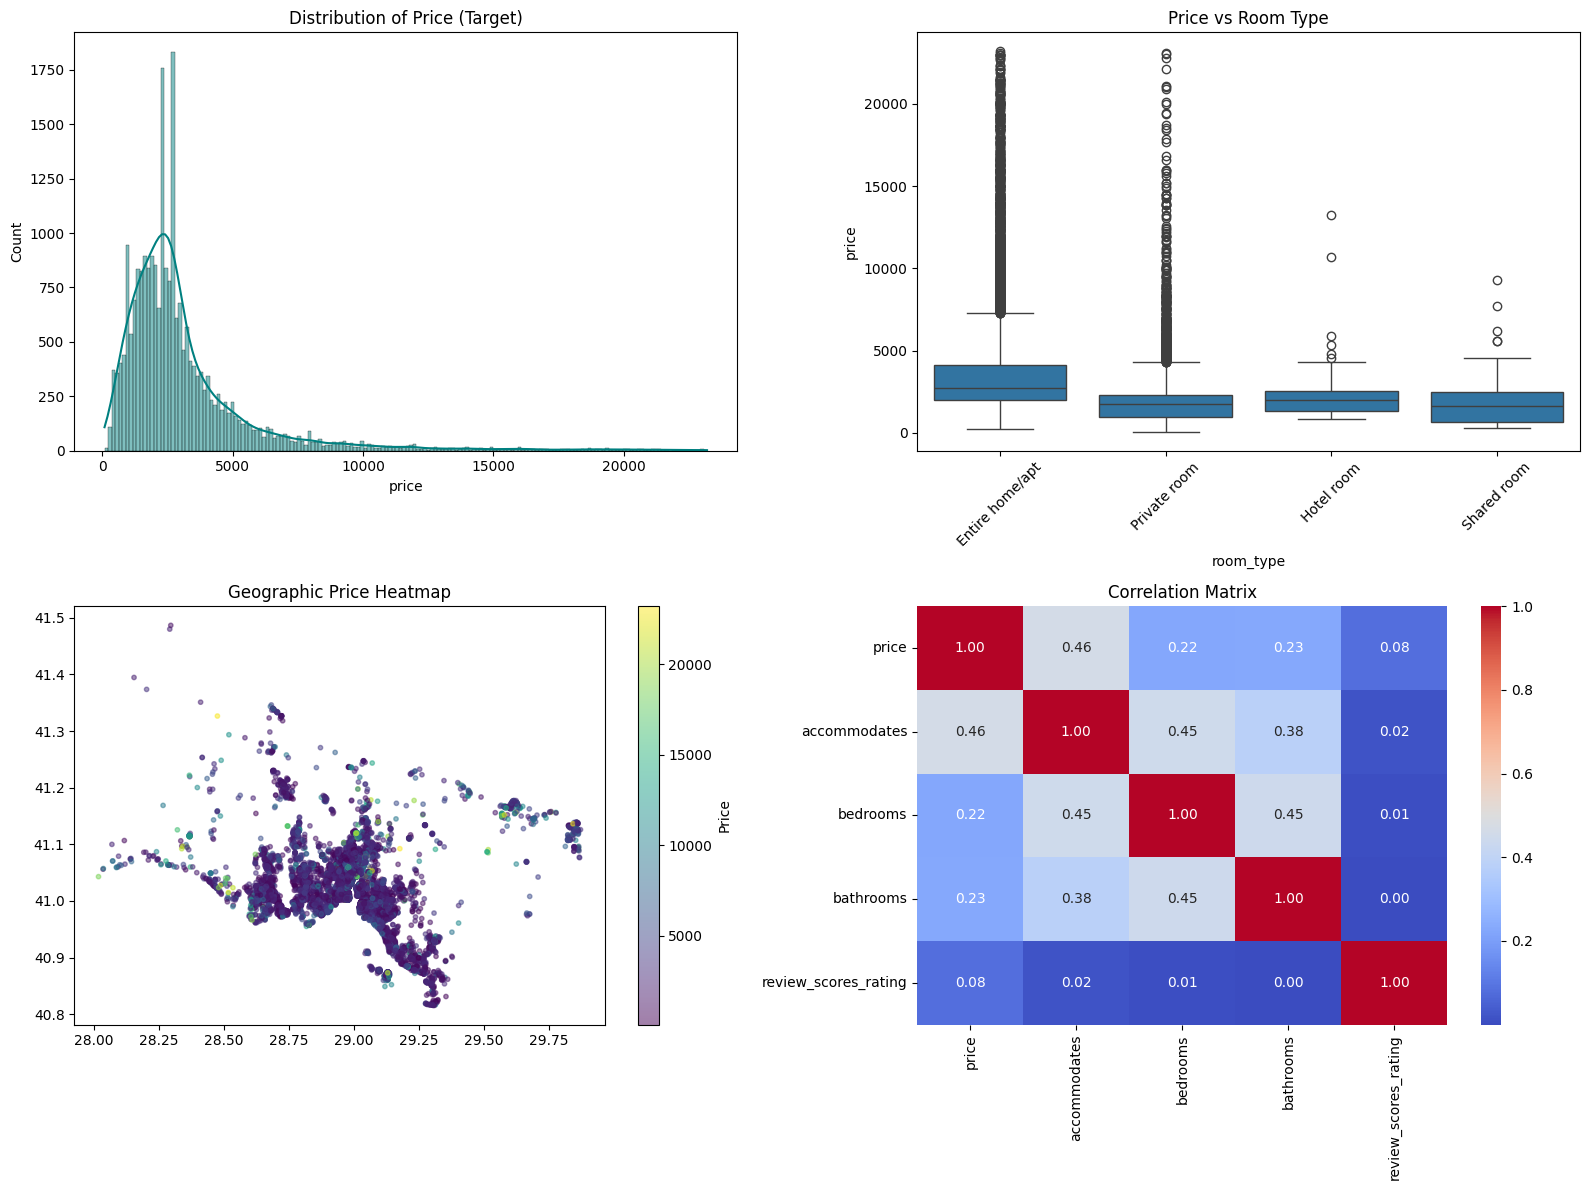


Step 2: Calendar features...

CREATING CALENDAR FEATURES
Processing 7-day window...
Processing 30-day window...
Processing 60-day window...
Processing 90-day window...
Detecting booking patterns...
Added 13 calendar features

CREATING CALENDAR FEATURES
Processing 7-day window...
Processing 30-day window...
Processing 60-day window...
Processing 90-day window...
Detecting booking patterns...
Added 13 calendar features

Step 3: Review features...

CREATING REVIEW FEATURES
Added 5 review features

CREATING REVIEW FEATURES
Added 5 review features

Step 4: Amenities features...

CREATING AMENITIES FEATURES
Added 10 amenity features

CREATING AMENITIES FEATURES
Added 10 amenity features

Step 5: Text features...
Processing text column: description...
Processing text column: description...
Processing text column: name...
Processing text column: name...

Step 6: Core features...

Creating ratio features...

Creating ratio features...
Creating location features...
Creating location features...

[I 2025-12-27 03:18:05,778] A new study created in memory with name: no-name-3c628949-520c-4598-9559-500005c45efc


Best RMSE: 0.4415417165891005
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}

OPTIMIZING XGBOOST WITH OPTUNA


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-27 03:18:42,744] Trial 0 finished with value: 0.41215823165812104 and parameters: {'n_estimators': 525, 'learning_rate': 0.08927180304353628, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.6468055921327309, 'colsample_bytree': 0.6467983561008608}. Best is trial 0 with value: 0.41215823165812104.
[I 2025-12-27 03:19:09,474] Trial 1 finished with value: 0.413258045455973 and parameters: {'n_estimators': 334, 'learning_rate': 0.07348118405270448, 'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.6061753482887408, 'colsample_bytree': 0.8909729556485984}. Best is trial 0 with value: 0.41215823165812104.
[I 2025-12-27 03:19:33,933] Trial 2 finished with value: 0.4421256168351132 and parameters: {'n_estimators': 800, 'learning_rate': 0.016305687346221478, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.6912726728878613, 'colsample_bytree': 0.7574269294896714}. Best is trial 0 with value: 0.41215823165812104.
[I 2025-12-27 03:20:28,196] Trial 3 finished with value: 

In [ ]:
# Load data
train, test, calendar, reviews = load_and_clean_data()

# Store test IDs
test_ids = test['id'].copy()

# Run pipeline
train_processed, test_processed = full_pipeline(train, test, calendar, reviews)

# Prepare data
X, y = prepare_model_data(train_processed)
X_test_final, _ = prepare_model_data(test_processed)
X_test_final = X_test_final.reindex(columns=X.columns, fill_value=0)


# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
)

# Train and evaluate
results = train_multiple_models(X_train, y_train, X_test, y_test)

ensemble_preds = ensemble_predictions(results)
evaluate_ensemble(y_test, ensemble_preds)


# Tune models
best_rf = tune_random_forest(X_train, y_train)
best_xgb_params = tune_xgboost(X_train, y_train, n_trials=30)

# Train final XGBoost

print("\nRetraining tuned XGBoost on FULL dataset...")

final_model = XGBRegressor(
    **best_xgb_params,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

final_model.fit(X, y)


y_val_log = final_model.predict(X_test)
y_val_price = np.expm1(y_val_log)
y_true_price = np.expm1(y_test)

rmse_price = np.sqrt(mean_squared_error(y_true_price, y_val_price))
mae_price = mean_absolute_error(y_true_price, y_val_price)

print("PRICE RMSE:", rmse_price)
print("PRICE MAE :", mae_price)

submission = make_predictions(final_model, X_test_final, test_ids)

print("\n" + "=" * 80)
print("PIPELINE COMPLETE!")
print("=" * 80)

<Figure size 1000x800 with 0 Axes>

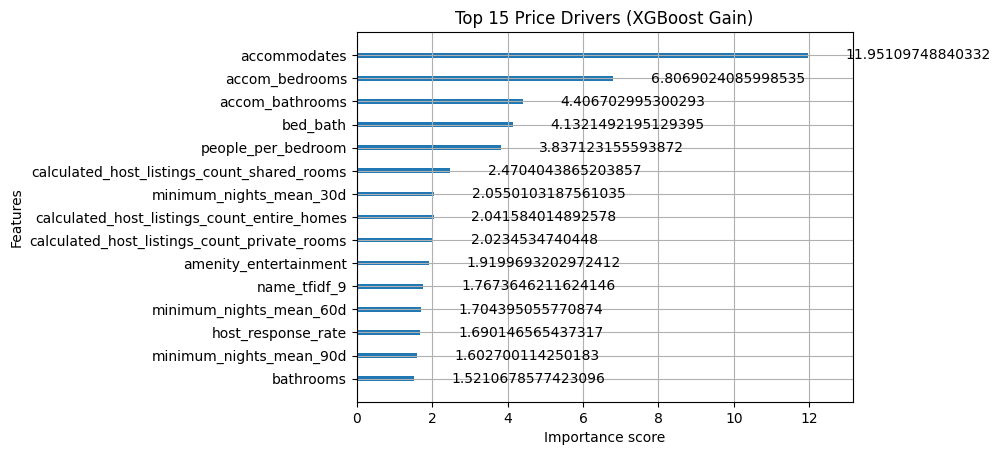

In [ ]:

    # 1. Comparison Table
    comparison_data = []
    for name, res in results.items():
        comparison_data.append({
            "Model": name.upper(),
            "RMSE": round(res['rmse'], 4),
            "R2": round(res['r2'], 4)
        })
    print("\nModel Performance Comparison:")
    print(pd.DataFrame(comparison_data).sort_values(by="RMSE").to_string(index=False))

    # 2. Residuals & Error Plots
    preds_log = final_model.predict(X_test)
    y_actual = np.expm1(y_test)
    y_pred = np.expm1(preds_log)

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    sns.scatterplot(x=y_actual, y=y_pred, alpha=0.5, ax=axes[0])
    axes[0].plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], '--r')
    axes[0].set_title("Actual vs. Predicted Prices")

    sns.histplot(y_actual - y_pred, kde=True, ax=axes[1], color='purple')
    axes[1].set_title("Residual Distribution (Errors)")
    plt.tight_layout()
    plt.show()

    # 3. Feature Importance
    plt.figure(figsize=(10, 6))
    plot_importance(final_model, max_num_features=10, importance_type='gain')
    plt.title("Top 10 Price Drivers (Gain)")
    plt.show()